# SIR modelling using 

In [8]:
from click import style
import numpy as np
import pandas as pd
from datetime import datetime 

from scipy import optimize
from scipy import integrate

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

sns.set(style='darkgrid')

mpl.rcParams['figure.figsize'] = (16,9)
pd.set_option('display.max_rows', 500)

Reading the data from the csv file

In [4]:
df_analyse = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep = ';')
df_analyse.sort_values('date', ascending=True).head()


,date,India,US,Italy,France,Vietnam,Germany
0,2020-01-22,0,1,0,0,0,0
1,2020-01-23,0,1,0,0,2,0
2,2020-01-24,0,2,0,2,2,0
3,2020-01-25,0,2,0,3,2,0
4,2020-01-26,0,5,0,3,2,0


Preparing the base values for the model

In [325]:
N0 = 1000000
beta = 0.4
gamma = 0.1

I0 = df_analyse.Germany[41]
S0 = N0 - I0
R0 =0



Defining the model for SIR

In [326]:
def SIR_model(SIR, beta, gamma):
    S,I,R = SIR
    ds_dt = -beta*S*I/N0
    dI_dt = beta*S*I/N0-gamma*I
    dR_dt = gamma*I

    return ([ds_dt, dI_dt, dR_dt])

# Simulative approach for calculating the SIR curve

In [327]:

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)


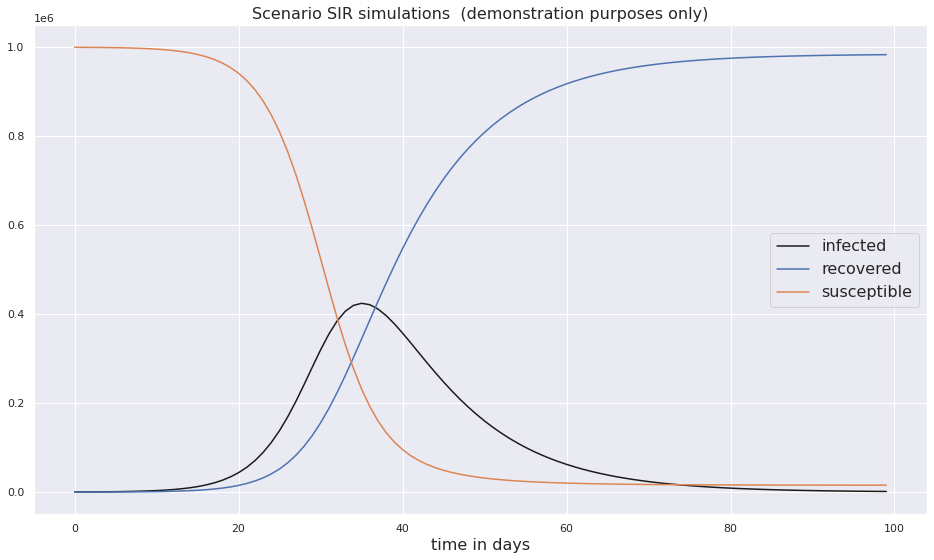

In [328]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

#ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Scenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting the parameters to SIR model

In [342]:
# Import libraries and make the data

from scipy import optimize
from scipy import integrate
ydata = np.array(df_analyse.Germany[41:])
t=np.arange(len(ydata))

In [343]:
# Initialization of variables
I0=ydata[0]
S0=N0-I0
R0=0
beta

0.4

In [344]:
def SIR_model_t(SIR, t, beta, gamma):

    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I

    return dS_dt,dI_dt,dR_dt

In [345]:

def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [346]:
popt=[0.4,0.1]
output = fit_odeint(t, *popt)

output.shape

(865,)

In [347]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata) # pcov returns covariance matrix (2D array) of the parameters with diagonale of the matrix as a variance values of the parameters
perr = np.sqrt(np.diag(pcov)) # Square root of the variance is the standard deviation of the parameter values. 
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])


/home/dell/anaconda3/envs/carlaEnv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/home/dell/anaconda3/envs/carlaEnv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """


standard deviation errors :  [1.19652957e-03 3.18942407e-05]  start infect: 188
Optimal parameters: beta = 0.10617174143838229  and gamma =  -0.004199468297040592


In [348]:
fitted=fit_odeint(t, *popt)
#fitted=fit_odeint(t, 0.082, -0.0000015)


print(fitted.shape)

(865,)


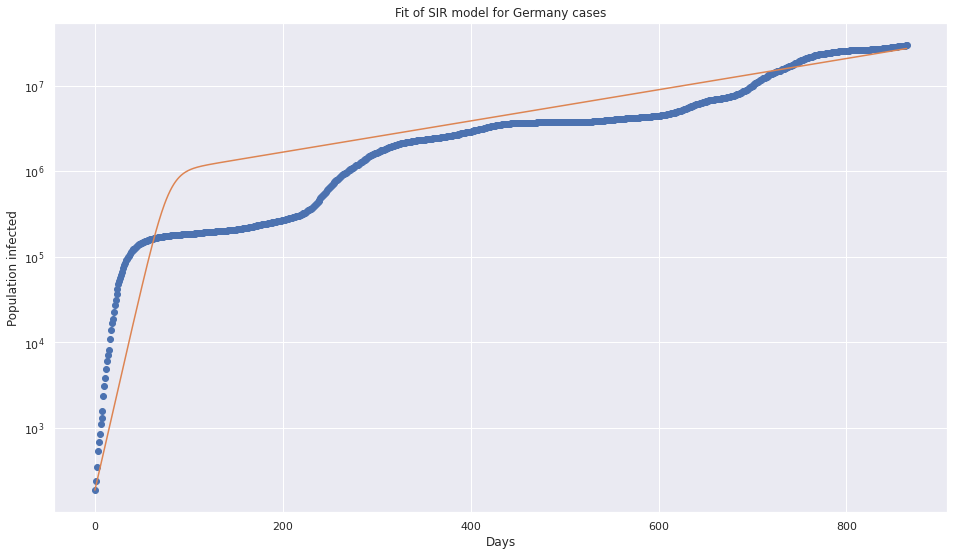

Optimal parameters: beta = 0.10617174143838229  and gamma =  -0.004199468297040592
Basic Reproduction Number R0  -25.28218667901424
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [349]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

# Dynamic beta in simulation

In [380]:
t_initial = 28
t_intro_measures = 14
t_hold = 21
t_relax = 15

beta_max = 0.3
beta_min = 0.2
gamma = 0.1

pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                       np.linspace(beta_max,beta_min,t_intro_measures),
                       np.array(t_hold*[beta_min]),
                       np.linspace(beta_min,beta_max,t_relax),
                       ))



In [381]:
pd_beta

array([0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
       0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
       0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
       0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
       0.3       , 0.3       , 0.3       , 0.3       , 0.3       ,
       0.3       , 0.3       , 0.3       , 0.3       , 0.29230769,
       0.28461538, 0.27692308, 0.26923077, 0.26153846, 0.25384615,
       0.24615385, 0.23846154, 0.23076923, 0.22307692, 0.21538462,
       0.20769231, 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.20714286,
       0.21428571, 0.22142857, 0.22857143, 0.23571429, 0.24285714,
       0.25      , 0.25714286, 0.26428571, 0.27142857, 0.27857

In [382]:

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_beta in pd_beta:
   
    new_delta_vec=SIR_model(SIR,each_beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)


In [385]:
propagation_rates.head()

,susceptible,infected,recoverd,recovered
0,999755.610603,225.589397,NaN,18.800000
1,999687.950324,270.690737,NaN,41.358940
2,999606.768443,324.803543,NaN,68.428013
3,999509.365697,389.725935,NaN,100.908368
4,999392.505281,467.613758,NaN,139.880961


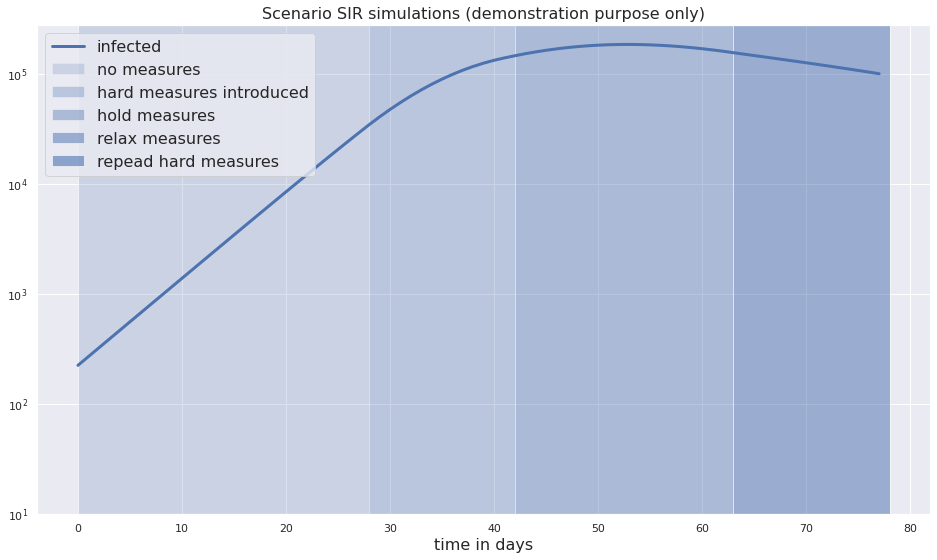

In [400]:
fig, ax1 = plt.subplots(1,1)


ax1.plot(propagation_rates.index, propagation_rates.infected, label= 'infected', linewidth =3)

t_phases = np.array([t_initial, t_intro_measures, t_hold, t_relax]).cumsum()


ax1.axvspan(0,t_phases[0], facecolor='b', alpha=0.2,label='no measures')
ax1.axvspan(t_phases[0],t_phases[1], facecolor='b', alpha=0.3,label='hard measures introduced')
ax1.axvspan(t_phases[1],t_phases[2], facecolor='b', alpha=0.4,label='hold measures')
ax1.axvspan(t_phases[2],t_phases[3], facecolor='b', alpha=0.5,label='relax measures')
ax1.axvspan(t_phases[3],len(propagation_rates.infected), facecolor='b', alpha=0.6,label='repead hard measures')

ax1.set_ylim(10, 1.5*max(propagation_rates.infected))
ax1.set_yscale('log')
ax1.set_title('Scenario SIR simulations (demonstration purpose only)',size =16)
ax1.set_xlabel('time in days', size =16)
ax1.legend(loc = 'best', prop = {'size':16});

In [388]:
t_phases

array([28, 42, 63, 78])

# Trying to make the dynamic dashboard

In [402]:
from click import style
import numpy as np
import pandas as pd
from datetime import datetime 

from scipy import optimize
from scipy import integrate

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from scipy import optimize
from scipy import integrate

sns.set(style='darkgrid')

mpl.rcParams['figure.figsize'] = (16,9)
pd.set_option('display.max_rows', 500)

In [1]:
def SIR_model(SIR, beta, gamma, N0):
    S,I,R = SIR
    ds_dt = -beta*S*I/N0
    dI_dt = beta*S*I/N0-gamma*I
    dR_dt = gamma*I

    return ([ds_dt, dI_dt, dR_dt])

In [2]:
# Dynamic value of the beta
t_initial = 28
t_intro_measures = 14
t_hold = 21
t_relax = 15

beta_max = 0.3
beta_min = 0.2
gamma = 0.1

pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                       np.linspace(beta_max,beta_min,t_intro_measures),
                       np.array(t_hold*[beta_min]),
                       np.linspace(beta_min,beta_max,t_relax),
                       ))

NameError: name 'np' is not defined

In [3]:
# Creating an empty data frame

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})